<a href="https://colab.research.google.com/github/GustaFTW/TensorFlow-ZTM/blob/main/section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Mon Dec 12 15:06:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-12-12 15:08:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   220MB/s    in 0.7s    

2022-12-12 15:08:06 (220 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32


train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst 
our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a simlar process, except the majority of our model's layers are going to come f rom TensorFlow Hub

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following featre vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [ ]:
# Let's compare the following two model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default10.
    
    Return:
      An uncompiled Keras Sequential model with model_url as feature extractor 
      layer and Dense output layer With num_classes output neurons.
    """

    # Download the pretrained model and save it as a Keras layer
    feature_extraction_layer = hub.KerasLayer(model_url, 
                                              trainable=False, # freeze the already learned patterns
                                              name="feature_extraction_layer",
                                              input_shape=IMG_SHAPE+(3,))
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                      num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="CategoricalCrossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=create_tensorboard_callback("tensorflow_hub", "resnet50V2"))

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221212-160204
Epoch 1/5
24/24 [==============================] - 16s 685ms/step - loss: 0.3112 - accuracy: 0.9453 - val_loss: 0.6722 - val_accuracy: 0.7788
Epoch 2/5
24/24 [==============================] - 16s 687ms/step - loss: 0.2634 - accuracy: 0.9573 - val_loss: 0.6472 - val_accuracy: 0.7824
Epoch 3/5
24/24 [==============================] - 16s 679ms/step - loss: 0.2240 - accuracy: 0.9693 - val_loss: 0.6437 - val_accuracy: 0.7884
Epoch 4/5
24/24 [==============================] - 16s 674ms/step - loss: 0.1902 - accuracy: 0.9787 - val_loss: 0.6320 - val_accuracy: 0.7860
Epoch 5/5
24/24 [==============================] - 16s 681ms/step - loss: 0.1668 - accuracy: 0.9827 - val_loss: 0.6368 - val_accuracy: 0.7836


Wow!

That's incredible, our transfer learning feature extractor model out performed ALL of the previoues models we built by hand... and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    
    
    """
    Returns separate loss curves for training and validation metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["Accuracy"]
    val_accuracy = history.history["val_Accuracy"]

    epochs = range(len(history.history["loss"])) # how many epochs we ran through

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_Accuracy")
    plt.plot(epochs, val_accuracy, label="val_Accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()


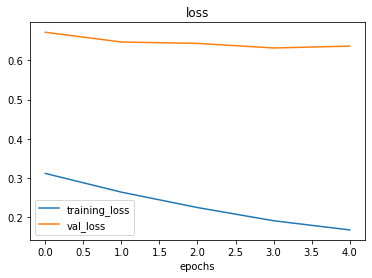

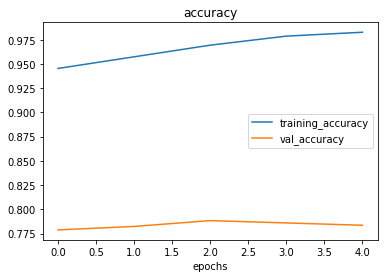

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 TensorFlow Hub Feature Extraction Model
efficient_net = create_model(efficientnet_url,
                      num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile EfficientNet model
efficient_net.compile(loss="CategoricalCrossentropy",
                      optimizer="Adam",
                      metrics=["Accuracy"])

In [ ]:
# Fit EfficientNet model
efficientnet_history = efficient_net.fit(train_data_10_percent,
                                         epochs=5,
                                         steps_per_epoch=len(train_data_10_percent),
                                         validation_data=test_data,
                                         validation_steps=len(test_data),
                                         callbacks=create_tensorboard_callback("tensorflow_hub", "efficientnetb0"))

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221212-161928
Epoch 1/5
24/24 [==============================] - 26s 738ms/step - loss: 1.8351 - Accuracy: 0.4200 - val_loss: 1.2724 - val_Accuracy: 0.7384
Epoch 2/5
24/24 [==============================] - 16s 686ms/step - loss: 1.0450 - Accuracy: 0.7653 - val_loss: 0.8516 - val_Accuracy: 0.8276
Epoch 3/5
24/24 [==============================] - 15s 659ms/step - loss: 0.7460 - Accuracy: 0.8360 - val_loss: 0.6896 - val_Accuracy: 0.8492
Epoch 4/5
24/24 [==============================] - 17s 741ms/step - loss: 0.6019 - Accuracy: 0.8640 - val_loss: 0.6045 - val_Accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 15s 665ms/step - loss: 0.5076 - Accuracy: 0.8933 - val_loss: 0.5533 - val_Accuracy: 0.8620


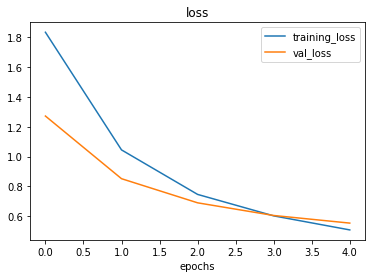

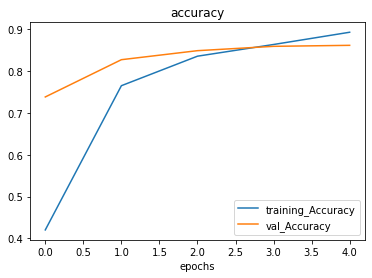

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficient_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficient_net.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no chages whatsoever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want other to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=222JXik89NvZESbLeUV8KaY7uqn9N7&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/8XYMVuxpQuOFEVSvZ6gVSw/#scalars

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/8XYMVuxpQuOFEVSvZ6gVSw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   8XYMVuxpQuOFEVSvZ6gVSw
	Created              2022-12-12 16:50:13 (6 minutes ago)
	Updated              2022-12-12 16:50:16 (6 minutes ago)
	Runs                 4
	Tags                 7
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918715
Total: 1 experiment(s)


In [ ]:
# Delete and experiment
# !tensorboard dev delete --experiment_id theIDtobeDeleted

In [ ]:
# Confirm the deletion by re-rechecking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/8XYMVuxpQuOFEVSvZ6gVSw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   8XYMVuxpQuOFEVSvZ6gVSw
	Created              2022-12-12 16:50:13 (8 minutes ago)
	Updated              2022-12-12 16:50:16 (7 minutes ago)
	Runs                 4
	Tags                 7
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918715
Total: 1 experiment(s)
